In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.text import *
from fastai.column_data import *

In [2]:
DATA_PATH = Path('data')
DATA_PATH
TMP_PATH = DATA_PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [3]:
sql_ids = np.load(TMP_PATH/'sql_ids.npy')
sql_itos = pickle.load(open(TMP_PATH/'sql_itos.pkl','rb'))
sql_stoi =  collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(sql_itos)})

In [184]:
def get_next_random(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)[0]
    pi = p.argsort()[-10:]
    i = np.random.choice(pi, p=softmax_np(p[pi]))
    return indices_char[i]

def softmax_np (nparray):
    ans = np.exp(nparray)
    return ans/ans.sum()

def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    p = to_np(p)
    
    return indices_char[i]

def get_sentence(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next(sentence[-8:]) # always get last three
        sentence += [tmp]
        counter = counter+1
        if counter> 500:
            break
    return sentence
        

def get_sentence_random(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next_random(sentence[-8:]) # always get last three
        sentence += [tmp]
        counter = counter+1
        if counter> 500:
            break
    return sentence
        

def show_sentence(inp):
    sentence =''
    captialize = False
    for i in inp:
        if i =='t_up':
            captialize = True
        else:            
            if captialize:
                sentence = sentence + " " + i.upper()       
           
            else:
                sentence = sentence +" " + i
            captialize = False
    return sentence

## Setup

Set up directory path

In [4]:
DATA_PATH = Path('data')
DATA_PATH
TMP_PATH = DATA_PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [9]:
dataset = pd.read_json(DATA_PATH/'train.json')
dataset.head()


,comments,description,id,sql,sql_plain,title,url
0,[],,586912,"SELECT p.Title,p.score,p.ViewCount,p.AnswerCou...","SELECT \np.Title,p.score,p.ViewCount,p.AnswerC...",Repent 151-160,http://data.stackexchange.com/stackoverflow/re...
1,[This is test data for my question to make thi...,,54791,"CREATE TABLE #CustomerDB ( ID int NOT NULL, NA...",-- This is test data for my question to make t...,This is test data for my question to make thin...,http://data.stackexchange.com/stackoverflow/re...
2,[],,611565,select Id from Comments where lower(Text) like...,select Id\nfrom Comments \nwhere lower(Text) l...,Accept answer,http://data.stackexchange.com/stackoverflow/re...
3,[],,612812,"DECLARE @From DATETIME = convert(DATETIME, '##...","DECLARE @From DATETIME = convert(DATETIME, '##...",Questions with most views created within 3 mon...,http://data.stackexchange.com/stackoverflow/re...
4,"[Most Prolific Answerers (with score), Shows t...",,325114,"SELECT TOP 50 OwnerUserId as [User Link], COUN...",-- Most Prolific Answerers (with score)\n-- Sh...,Most Prolific Answers,http://data.stackexchange.com/stackoverflow/re...


In [10]:
SQL = dataset.sql

In [11]:
## Transform the text to be tokenize readily, as certain token has special meaning in SQL, ie. "." means the schema relation
token_replaced = {',' : ' , ',
                 '#' : ' # ',
                 '@' : ' @ ',
                 '!' : ' ! ',
                 '.' : ' . ',
                 '%' : ' % ',
                 '?' : ' ? ',
                 ')' : ' ) ',
                 '(' : ' ( ',
                 '=' : ' = ',
                 '/' : ' / ',
                 '*' : ' * '}
    

In [15]:
def fixup(x):
    for bereplaced, replace in token_replaced.items():        
        x = x.replace(bereplaced, replace).lower() # CASE insentive for SQL
    return x

In [16]:
SQL = SQL.apply(fixup)## Sanity Check
SQL.iloc[0]

'select p . title , p . score , p . viewcount , p . answercount , p . commentcount , len ( p . body )  as ques_size ,  p . favoritecount , p . id ,  u . reputation as user_repo , u . creationdate as user_join_date ,  datediff ( minute ,  p . creationdate ,  a . creationdate )  as qatimegap from posts as p ,  posts as a ,  users as u where p . id = a . parentid and p . owneruserid = u . id and a . creationdate  =   ( select min ( tau . creationdate )  from posts tau where tau . parentid = p . id group by tau . parentid )  and  (  p . title like \' % recommended method for handling unsupportedencodingexception from string . getbytes ( "utf-8" )  % \' or p . title like \' % way to format strings with " ? " parameters to full string in java ?  % \' or p . title like \' % how to parse a string without regular expressions % \' or p . title like \' % how to replace string only once without regex in java ?  % \' or p . title like \' % efficiently removing specific characters  ( some punctuatio

In [17]:
SQL.iloc[0]

'select p . title , p . score , p . viewcount , p . answercount , p . commentcount , len ( p . body )  as ques_size ,  p . favoritecount , p . id ,  u . reputation as user_repo , u . creationdate as user_join_date ,  datediff ( minute ,  p . creationdate ,  a . creationdate )  as qatimegap from posts as p ,  posts as a ,  users as u where p . id = a . parentid and p . owneruserid = u . id and a . creationdate  =   ( select min ( tau . creationdate )  from posts tau where tau . parentid = p . id group by tau . parentid )  and  (  p . title like \' % recommended method for handling unsupportedencodingexception from string . getbytes ( "utf-8" )  % \' or p . title like \' % way to format strings with " ? " parameters to full string in java ?  % \' or p . title like \' % how to parse a string without regular expressions % \' or p . title like \' % how to replace string only once without regex in java ?  % \' or p . title like \' % efficiently removing specific characters  ( some punctuatio

In [4]:
sql_tok = Tokenizer.proc_all_mp(partition_by_cores(SQL)) 

NameError: name 'SQL' is not defined

In [19]:
sql_tok[0]

['select',
 'p',
 '.',
 'title',
 ',',
 'p',
 '.',
 'score',
 ',',
 'p',
 '.',
 'viewcount',
 ',',
 'p',
 '.',
 'answercount',
 ',',
 'p',
 '.',
 'commentcount',
 ',',
 'len',
 '(',
 'p',
 '.',
 'body',
 ')',
 'as',
 'ques_size',
 ',',
 'p',
 '.',
 'favoritecount',
 ',',
 'p',
 '.',
 'i',
 'd',
 ',',
 'u',
 '.',
 'reputation',
 'as',
 'user_repo',
 ',',
 'u',
 '.',
 'creationdate',
 'as',
 'user_join_date',
 ',',
 'datediff',
 '(',
 'minute',
 ',',
 'p',
 '.',
 'creationdate',
 ',',
 'a',
 '.',
 'creationdate',
 ')',
 'as',
 'qatimegap',
 'from',
 'posts',
 'as',
 'p',
 ',',
 'posts',
 'as',
 'a',
 ',',
 'users',
 'as',
 'u',
 'where',
 'p',
 '.',
 'i',
 'd',
 '=',
 'a',
 '.',
 'parentid',
 'and',
 'p',
 '.',
 'owneruserid',
 '=',
 'u',
 '.',
 'i',
 'd',
 'and',
 'a',
 '.',
 'creationdate',
 '=',
 '(',
 'select',
 'min',
 '(',
 'tau',
 '.',
 'creationdate',
 ')',
 'from',
 'posts',
 'tau',
 'where',
 'tau',
 '.',
 'parentid',
 '=',
 'p',
 '.',
 'i',
 'd',
 'group',
 'by',
 'tau',
 '.',

In [20]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common()]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([0] + [stoi[o] for o in p] + [2]) for p in tok]) # pad bos at beginning and eos at the end
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [21]:
sql_ids,sql_itos,sql_stoi = toks2ids(sql_tok,'sql')

In [5]:
sql_ids_concat= []
for i in sql_ids:
    sql_ids_concat += i

In [6]:
sql_ids.shape

(24594,)

In [7]:
vocab_size = len(sql_itos)
print('total chars:', vocab_size)

total chars: 23125


## Three char model

### Create inputs

Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters

In [8]:
idx = sql_ids_concat

In [9]:
char_indices = sql_stoi
indices_char = sql_itos

### Create and train model

Pick a size for our hidden state

In [10]:
n_hidden = 256
n_fac = 42

## Wrap Char3Model to fastai learner

### Create inputs

This is the size of our unrolled RNN.

In [11]:
cs=5

For each of 0 through 7, create a list of every 8th character with that starting point. These will be the 8 inputs to our model.

In [12]:
c_in_dat = [[sql_ids_concat[i+j] for i in range(cs)] for j in range(len(sql_ids_concat)-cs)]

Then create a list of the next character in each of these series. This will be the labels for our model.

In [13]:
c_out_dat = [sql_ids_concat[j+cs] for j in range(len(sql_ids_concat)-cs)]

In [14]:
xs = np.stack(c_in_dat, axis=0)

In [15]:
xs

array([[  0,  13,  18,   4, 102],
       [ 13,  18,   4, 102,   5],
       [ 18,   4, 102,   5,  18],
       ...,
       [ 27,  20,   8, 252,  30],
       [ 20,   8, 252,  30,   8],
       [  8, 252,  30,   8, 124]])

In [16]:
xs.shape

(2146779, 5)

In [17]:
y = np.stack(c_out_dat)

In [18]:
y

array([  5,  18,   4, ...,   8, 124,   2])

So each column below is one series of 8 characters from the text.

In [19]:
xs[:cs,:cs]

array([[  0,  13,  18,   4, 102],
       [ 13,  18,   4, 102,   5],
       [ 18,   4, 102,   5,  18],
       [  4, 102,   5,  18,   4],
       [102,   5,  18,   4,  33]])

...and this is the next character after each sequence.

In [20]:
y[:cs]

array([ 5, 18,  4, 33,  5])

### Create and train model

In [21]:
val_idx = get_cv_idxs(len(sql_ids_concat)-cs-1)

In [22]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=2048)

In [23]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac+n_hidden, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:
            inp = torch.cat((h, self.e(c)), 1)          
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [24]:
m = CharLoopConcatModel(vocab_size, n_fac).cuda()
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
model = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)


C:\Users\NokChan\Anaconda3\envs\fastai\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 GeForce 930M which is of cuda capability 5.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [24]:
# it = iter(md.trn_dl)
# *xs,yt = next(it)
# t = m(*V(xs))

In [25]:
model.fit(1e-3,1, cycle_len=1,use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.165478   3.135849  



[3.1358491721754476]

In [24]:
# model.save('tmp1')
model.load('tmp1')

In [25]:
model.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 64%|██████▍   | 541/839 [08:49<04:51,  1.02it/s, loss=11.2]

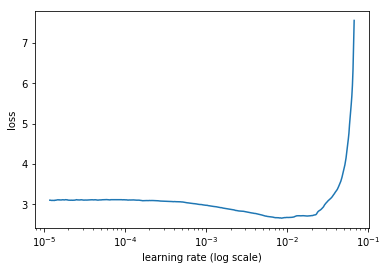

In [26]:
model.sched.plot()

In [27]:
model.fit(1e-4,1, cycle_len=1,use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 10/839 [00:07<09:40,  1.43it/s, loss=3.12]

Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\NokChan\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\NokChan\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\NokChan\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      2.91034    2.919186  



[2.919185948091741]

In [28]:
model.save('tmp2')

In [25]:
model.load('tmp2')

In [26]:
model.fit(1e-3,1, cycle_len=2,use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.242579   2.22189   
  0%|          | 0/839 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at c:\pytorch\torch\lib\thc\generic/THCStorage.cu:58

In [179]:
a=get_sentence(['select','*','from','where','users'])

In [180]:
b=get_sentence_random(['select','*','from','where','users'])

In [181]:
show_sentence(b)

' select * from where users . i d = posts . i d = posttags . postid = tags . postid inner join posttags pt on pt . tagid = postid and v . postid = a . parentid where u . displayname > 0 group by tagname order by upvotes , count ( * ) over ( order by count ( * ) from posts a where a . parentid = posts . i d , posts . i d ) , p . displayname , p . body as [ post link ] , reputation from posthistory _eos_'

In [182]:
show_sentence(a)

' select * from where users . i d = # # userid # # and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p . posttypeid = 1 and p 

In [138]:
show_sentence(a)

" SELECT * FROM where customer LIKE ' % < % ' or LOWER ( location ) LIKE ' % india % ' ORDER by reputation DESC ; _eos_"

In [ ]:
get_next(['select', '*', 'from'])

### Test model

In [98]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [99]:
get_next('for thos')

'e'

In [100]:
get_next('part of ')

't'

In [101]:
get_next('queens a')

'n'

## RNN with pytorch

In [108]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

In [109]:
m = CharRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [110]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [111]:
t = m.e(V(torch.stack(xs)))
t.size()

torch.Size([8, 512, 42])

In [112]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

(torch.Size([8, 512, 256]), torch.Size([1, 512, 256]))

In [113]:
t = m(*V(xs)); t.size()

torch.Size([512, 85])

In [114]:
fit(m, md, 4, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.86065  1.84255]                                 
[ 1.       1.68014  1.67387]                                 
[ 2.       1.58828  1.59169]                                 
[ 3.       1.52989  1.54942]                                 



In [115]:
set_lrs(opt, 1e-4)

In [116]:
fit(m, md, 2, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.46841  1.50966]                                 
[ 1.       1.46482  1.5039 ]                                 



### Test model

In [117]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [118]:
get_next('for thos')

'e'

In [119]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [120]:
get_next_n('for thos', 40)

'for those the same the same the same the same th'

## Multi-output model

### Setup

Let's take non-overlapping sets of characters this time

In [19]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(idx)-cs-1, cs)]

Then create the exact same thing, offset by 1, as our labels

In [20]:
c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)]

In [21]:
xs = np.stack(c_in_dat)
xs.shape

(75111, 8)

In [22]:
ys = np.stack(c_out_dat)
ys.shape

(75111, 8)

In [23]:
xs[:cs,:cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [ 1,  1, 43, 45, 40, 40, 39, 43],
       [33, 38, 31,  2, 73, 61, 54, 73],
       [ 2, 44, 71, 74, 73, 61,  2, 62],
       [72,  2, 54,  2, 76, 68, 66, 54],
       [67,  9,  9, 76, 61, 54, 73,  2],
       [73, 61, 58, 67, 24,  2, 33, 72],
       [ 2, 73, 61, 58, 71, 58,  2, 67]])

In [24]:
ys[:cs,:cs]

array([[42, 29, 30, 25, 27, 29,  1,  1],
       [ 1, 43, 45, 40, 40, 39, 43, 33],
       [38, 31,  2, 73, 61, 54, 73,  2],
       [44, 71, 74, 73, 61,  2, 62, 72],
       [ 2, 54,  2, 76, 68, 66, 54, 67],
       [ 9,  9, 76, 61, 54, 73,  2, 73],
       [61, 58, 67, 24,  2, 33, 72,  2],
       [73, 61, 58, 71, 58,  2, 67, 68]])

### Create and train model

In [127]:
val_idx = get_cv_idxs(len(xs)-cs-1)

In [128]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [133]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp), dim=-1)

In [134]:
m = CharSeqRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [135]:
it = iter(md.trn_dl)
*xst,yt = next(it)

In [136]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [137]:
fit(m, md, 4, opt, nll_loss_seq)

A Jupyter Widget

[ 0.       2.59241  2.40251]                                
[ 1.       2.28474  2.19859]                                
[ 2.       2.13883  2.08836]                                
[ 3.       2.04892  2.01564]                                



In [138]:
set_lrs(opt, 1e-4)

In [139]:
fit(m, md, 1, opt, nll_loss_seq)

A Jupyter Widget

[ 0.       1.99819  2.00106]                               



### Identity init!

In [140]:
m = CharSeqRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [141]:
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))


    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      1     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 256x256 (GPU 0)]

In [142]:
fit(m, md, 4, opt, nll_loss_seq)

A Jupyter Widget

[ 0.       2.39428  2.21111]                                
[ 1.       2.10381  2.03275]                                
[ 2.       1.99451  1.96393]                               
[ 3.       1.93492  1.91763]                                



In [143]:
set_lrs(opt, 1e-3)

In [144]:
fit(m, md, 4, opt, nll_loss_seq)

A Jupyter Widget

[ 0.       1.84035  1.85742]                                
[ 1.       1.82896  1.84887]                                
[ 2.       1.81879  1.84281]                               
[ 3.       1.81337  1.83801]                                



## Stateful model

### Setup

In [15]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

PATH='data/nietzsche/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

models/  nietzsche.txt  trn/  val/


In [16]:
%ls {PATH}trn

trn.txt


In [18]:
TEXT = data.Field(lower=True, tokenize=list)
bs=64; bptt=8; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(963, 56, 1, 493747)

### RNN

In [21]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [22]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [23]:
fit(m, md, 4, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.81983  1.81247]                                 
[ 1.       1.63097  1.66228]                                 
[ 2.       1.54433  1.57824]                                 
[ 3.       1.48563  1.54505]                                 



In [24]:
set_lrs(opt, 1e-4)

fit(m, md, 4, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.4187   1.50374]                                 
[ 1.       1.41492  1.49391]                                 
[ 2.       1.41001  1.49339]                                 
[ 3.       1.40756  1.486  ]                                 



### RNN loop

In [9]:
# From the pytorch source

def RNNCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    return F.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh, b_hh))

In [12]:
class CharSeqStatefulRnn2(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNNCell(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp = []
        o = self.h
        for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
        outp = self.l_out(torch.stack(outp))
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [13]:
m = CharSeqStatefulRnn2(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [8]:
fit(m, md, 4, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.81013  1.7969 ]                                 
[ 1.       1.62515  1.65346]                                 
[ 2.       1.53913  1.58065]                                 
[ 3.       1.48698  1.54217]                                 



### GRU

In [18]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [ ]:
# From the pytorch source code - for reference

def GRUCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    gi = F.linear(input, w_ih, b_ih)
    gh = F.linear(hidden, w_hh, b_hh)
    i_r, i_i, i_n = gi.chunk(3, 1)
    h_r, h_i, h_n = gh.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + resetgate * h_n)
    return newgate + inputgate * (hidden - newgate)

In [27]:
m = CharSeqStatefulGRU(md.nt, n_fac, 512).cuda()

opt = optim.Adam(m.parameters(), 1e-3)

In [29]:
fit(m, md, 6, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.68409  1.67784]                                 
[ 1.       1.49813  1.52661]                                 
[ 2.       1.41674  1.46769]                                 
[ 3.       1.36359  1.43818]                                 
[ 4.       1.33223  1.41777]                                 
[ 5.       1.30217  1.40511]                                 



In [30]:
set_lrs(opt, 1e-4)

In [31]:
fit(m, md, 3, opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.22708  1.36926]                                 
[ 1.       1.21948  1.3696 ]                                 
[ 2.       1.22541  1.36969]                                 



### Putting it all together: LSTM

In [12]:
from fastai import sgdr

n_hidden=512

In [22]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [23]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [18]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [19]:
fit(m, md, 2, lo.opt, F.nll_loss)

A Jupyter Widget

[ 0.       1.72032  1.64016]                                 
[ 1.       1.62891  1.58176]                                 



In [20]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb)

A Jupyter Widget

[ 0.       1.47969  1.4472 ]                                 
[ 1.       1.51411  1.46612]                                 
[ 2.       1.412    1.39909]                                 
[ 3.       1.53689  1.48337]                                 
[ 4.       1.47375  1.43169]                                 
[ 5.       1.39828  1.37963]                                 
[ 6.       1.34546  1.35795]                                 
[ 7.       1.51999  1.47165]                                 
[ 8.       1.48992  1.46146]                                 
[ 9.       1.45492  1.42829]                                 
[ 10.        1.42027   1.39028]                              
[ 11.        1.3814    1.36539]                              
[ 12.        1.33895   1.34178]                              
[ 13.        1.30737   1.32871]                              
[ 14.        1.28244   1.31518]                              



In [44]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

A Jupyter Widget

[ 0.       1.46053  1.43462]                                 
[ 1.       1.51537  1.47747]                                 
[ 2.       1.39208  1.38293]                                 
[ 3.       1.53056  1.49371]                                 
[ 4.       1.46812  1.43389]                                 
[ 5.       1.37624  1.37523]                                 
[ 6.       1.3173   1.34022]                                 
[ 7.       1.51783  1.47554]                                 
[ 8.       1.4921   1.45785]                                 
[ 9.       1.44843  1.42215]                                 
[ 10.        1.40948   1.40858]                              
[ 11.        1.37098   1.36648]                              
[ 12.        1.32255   1.33842]                              
[ 13.        1.28243   1.31106]                              
[ 14.        1.25031   1.2918 ]                              
[ 15.        1.49236   1.45316]                              
[ 16.   

### Test

In [45]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [46]:
get_next('for thos')

'e'

In [47]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [50]:
print(get_next_n('for thos', 400))

for those the skemps), or
imaginates, though they deceives. it should so each ourselvess and new
present, step absolutely for the
science." the contradity and
measuring, 
the whole!

293. perhaps, that every life a values of blood
of
intercourse when it senses there is unscrupulus, his very rights, and still impulse, love?
just after that thereby how made with the way anything, and set for harmless philos
